In [3]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random
import scipy.sparse as sp
import networkx as nx
# Set random seed
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

'''
Fron gnc.utils
'''

def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

####################################################################
#################INIZIALISATION ###############

####################################################################


# Get adjacency matrix
# Get degree matrix
def edges_tuples(filepath,remove_permutations=True):
    neigbors=pd.read_csv(filepath,header=0)
    neigbors=neigbors.sort_index()
    neigbors=neigbors.values
    neigborsTouple=[tuple(l) for l in neigbors]
    del neigbors
    if remove_permutations:
        neigborsTouple_no_permu=set(tuple(sorted(l)) for l in neigborsTouple)
        if len(neigborsTouple_no_permu)==len(neigborsTouple)/2:
            print("Single direction edges were created")
        else:
            print("After removing permutations, dimentions dont match")
        del neigborsTouple
        neigborsTouple_no_permu=sorted(neigborsTouple_no_permu)
        return neigborsTouple_no_permu
    else:
        print("Double direction edges were created")
        return neigborsTouple
    

# This base graph remains the same
def base_node_info(frame0File,neighbors_tuples):
    senders_arr=[]
    receivers_arr=[]
    el_pos=pd.read_csv(frame0File,header=0,usecols=[" Element Label","X","Y","Z"],index_col=" Element Label")
    el_pos=el_pos.values
    el_pos=el_pos*1000
    #el_pos=normalizePos(el_pos,1,-1)
    
    for edge in neighbors_tuples:
        sender=edge[0]-1
        receiver=edge[1]-1
        senders_arr.append(sender)
        receivers_arr.append(receiver)


    return el_pos



def change_training_dir(tr_dirs,send_rec_arr):
       
    path=tr_dirs
    
    in_tr_path=os.listdir(path)
    stress_path=[file for file in in_tr_path if file[-10:]=='stress.csv']
    stress_npz_path=[file for file in in_tr_path if file[-4:]=='.npz']
    global_path=[file for file in in_tr_path if file[:5]=='RNode' ]
    nodes_pos=base_node_info(path+stress_path[0],send_rec_arr)
        # Element features
    
    stress_arr= np.load(path+stress_npz_path[0])
    m_vm_data=stress_arr["peeq"]
    #m_vm_data=np.cbrt(m_vm_data)
    m_status_data= stress_arr["status"]
        # global features file 
    m_tool_info=pd.read_fwf(path+global_path[0],header=1,skiprows=1)
    m_tool_info=m_tool_info.values
    header_pos=0
    while all(np.isnan(m_tool_info[header_pos,...])):
        header_pos+=1

    m_tool_info=m_tool_info[...,1:]
    m_tool_info=m_tool_info[header_pos:header_pos+np.shape(m_vm_data)[1],...] # replace this by the lenght of stresses
    column_index=0
    while (column_index < np.shape(m_tool_info)[1]):
        if all(np.isnan(m_tool_info[...,column_index])):
            m_tool_info=np.delete(m_tool_info, np.s_[column_index], 1)
        else:
            column_index+=1
    m_tool_cf=m_tool_info[...,:3]/200
    
    tool_pos=m_tool_info[...,5:]*1000
    
    m_tool_info=np.append(m_tool_cf,tool_pos,axis=1)

    return m_tool_info,m_vm_data,m_status_data,nodes_pos

def CreateFeaturesFrame(init_adj,tool_positions,stresses,n_positions,frame_to_predict):    
    vs_in= stresses[...,frame_to_predict-1]
    delta_vs_presente= (-stresses[...,frame_to_predict]+stresses[...,frame_to_predict-1])
    pos_tool_f=tool_positions[frame_to_predict][-3:]
    force_tool=tool_positions[frame_to_predict][:3]
    n_rel_pos=pos_tool_f-n_positions
    tool_abs_broadcast=force_tool+(0*n_positions)
    unit_vector_1 =np.divide(n_rel_pos , np.linalg.norm(n_rel_pos,axis=1).reshape((-1, 1)))
    unit_vector_2 = np.divide(tool_abs_broadcast , np.linalg.norm(tool_abs_broadcast,axis=1).reshape((-1, 1)))
    dot_product = np.linalg.norm(np.cross(unit_vector_1, unit_vector_2),axis=1)
    dot_product = 1 - dot_product/max(dot_product)
    feat_mx=np.append(n_rel_pos,np.transpose([dot_product,1-vs_in,vs_in]),axis=-1)
    delta_vs_presente=np.transpose([delta_vs_presente])
    # Inpu tensor
    input_tf=tf.convert_to_tensor(feat_mx,  dtype=tf.float32)
    #Target tensor
    target_tf=tf.convert_to_tensor(delta_vs_presente, dtype=tf.float32)
    
    off_nodes=np.argwhere(vs_in<0.2)[...,-1]

    dense_adj=init_adj.toarray()
    adj_shape=np.shape(dense_adj)
    for rmv_n in off_nodes:
        dense_adj[rmv_n]=np.zeros(adj_shape[1],dtype=int)
        dense_adj[...,rmv_n]=np.zeros(adj_shape[0],dtype=int)
    
    supp=sp.csr_matrix(dense_adj)
    supp=preprocess_adj(supp)
    
    ### Tensors
    #adj as sparse tensor
    adj_tf=tf.sparse.SparseTensor(supp[0], supp[1], supp[2])
    adj_tf=tf.dtypes.cast(adj_tf,tf.float32) 
    #adj_tf=tf.sparse.to_dense(tf.sparse.reorder(adj_tf))
    #features as sparse tensor
    features_tf=tf.convert_to_tensor(input_tf, dtype=tf.float32)
    # cast to tensorflow all arr
    y_train_tf=tf.convert_to_tensor(target_tf, dtype=tf.float32)
        
    return adj_tf,features_tf,y_train_tf



###############################################################################################################################################################
###############################################################################################################################################################
send_rec_arr= edges_tuples('/home/mara/Documents/gcn/gcn/tinymesh/tinyEleNeighborhood.csv',remove_permutations=False)
#send_rec_arr=np.concatenate( (np.array(send_rec_arr,dtype='int32')), axis=0 ).reshape((len(send_rec_arr), 2))
adj = nx.adjacency_matrix(nx.Graph(send_rec_arr))

num_supports = 1

tool_info,vm_data,status_data,n_positions= change_training_dir('/home/mara/Documents/gcn/gcn/tinymesh/',send_rec_arr)
initial_pos=[0,0,0,0, -1.13909,  7.67766e-001]
tool_info=initial_pos+tool_info

f=25
support,t_features,t_yr=CreateFeaturesFrame(adj,tool_info,vm_data,n_positions,f)

in_size=np.shape(t_features)[1]
encoder=[in_size,in_size]
conv=2
decoder=[2,1]
learning_rate= 1e-2

Double direction edges were created


In [84]:
np.shape(t_features)[1]

6

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

_=plt.hist(t_features[...,-3],10)

In [5]:
import GCNLayer
import sonnet as snt
learning_rate=0.01
conv=3

model=GCNLayer.GCN(encoder_arr=encoder,convolution_kernel_1=conv,convolution_kernel_2=np.shape(t_yr)[1])
optimizer = tf.keras.optimizers.Adam(learning_rate)


def ComputeLoss(labels, preds,inp_tr):
    bce = tf.keras.losses.BinaryCrossentropy() 
    pred_binary=inp_tr[...,-2:]-tf.concat([-preds,preds], 1) 
    real_binary=inp_tr[...,-2:]-tf.concat([-labels,labels], 1) 
    
    _loss=50*bce(real_binary, pred_binary)
    #_loss+= tf.nn.l2_loss(model.trainable_variables[-1])*5e-4
    return _loss


def update_step(inputs_tr,adj, targets_tr):
    with tf.GradientTape() as tape:
        output_ops_tr = model(inputs_tr,adj)
        # Loss.
        loss_tr = ComputeLoss(targets_tr,output_ops_tr,inputs_tr)
        

    gradients = tape.gradient(loss_tr, model.trainable_variables)
    #grads = tf.distribute.get_replica_context().all_reduce('sum', gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    #optimizer.apply(gradients, model.trainable_variables)
    return loss_tr,output_ops_tr

In [6]:
input_signature = [tf.TensorSpec.from_tensor(t_features),tf.SparseTensorSpec(shape=support.get_shape(),dtype=tf.dtypes.float32),tf.TensorSpec.from_tensor(t_yr)]
compiled_update_step = tf.function(update_step, input_signature=input_signature)

In [11]:
frames_arr=[50,51,52,53,54]

# Train model
for epoch in range(200000):
    random.shuffle(frames_arr)
    loss_epoch=0
    for frame_to_train in frames_arr:
        support,inputs_tr,targets_tr=CreateFeaturesFrame(adj,tool_info,vm_data,n_positions,frame_to_train)
        loss_tr,outs = compiled_update_step(inputs_tr, support, targets_tr)
        loss_epoch+= loss_tr
    if epoch%20==0:
        loss_epoch=loss_epoch/len(frames_arr)
        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(loss_epoch))


Epoch: 0001 train_loss= 6.43293
Epoch: 0021 train_loss= 6.09899
Epoch: 0041 train_loss= 5.69798
Epoch: 0061 train_loss= 5.63071


KeyboardInterrupt: 

In [6]:
frames_arr=[50,51,52,53,54]

# Train model
for epoch in range(200000):
    random.shuffle(frames_arr)
    loss_epoch=0
    for frame_to_train in frames_arr:
        support,inputs_tr,targets_tr=CreateFeaturesFrame(adj,tool_info,vm_data,n_positions,frame_to_train)
        loss_tr,outs = compiled_update_step(inputs_tr, support, targets_tr)
        loss_epoch+= loss_tr
    if epoch%10==0:
        loss_epoch=loss_epoch/len(frames_arr)
        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(loss_epoch))

Epoch: 0001 train_loss= 5.25787


KeyboardInterrupt: 

In [19]:

bce = tf.keras.losses.BinaryCrossentropy() 
bce(real_binary, pred_binary)

<tf.Tensor: shape=(), dtype=float32, numpy=1.5430278>

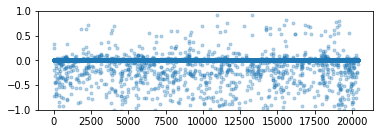

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

delta=targets_tr-outs
ax1 = plt.subplot(211)
deltas_peed=delta[...,0]

plt.ylim(-1,1)
axs1=plt.plot(range(np.shape(delta)[0]), delta,'.',alpha=0.3)